<a href="https://colab.research.google.com/github/mandalanil/Semi-Automated-workflow-for-flood-risk-mapping/blob/main/Spatio_temporal_flowforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refactored Data Preprocessing for 30-Minute Event Samples

This section re-implements the data preprocessing pipeline to create 3-day, 30-minute rainfall-runoff event samples, incorporating static basin characteristics. Each sample will represent a rainfall-runoff event of 144 time steps (3 days * 48 steps/day) and will include both dynamic time series data (Discharge and Rainfall) and static basin features. The goal is to structure the data into NumPy arrays ready for training a spatio-temporal model.

Based on the refined plan:

1.  **Data Loading & Initial Preprocessing (30-min)**
2.  **Define Rainfall Event Criteria (Daily)**
3.  **Aggregate Rainfall to Daily for Event Identification**
4.  **Identify Event Start Times (Daily)**
5.  **Extract 30-Minute Event Windows**
6.  **Incorporate Static Basin Characteristics**
7.  **Structure Event Samples & Scaling**
8.  **Review and Refine Event Samples (Optional)**
9.  **Prepare Data for Model (Final Arrays)**

## 1. Data Loading & Initial Preprocessing (30-min)

**Subtask:** Load all available time series data (discharge, rainfall) at their original 30-minute interval. Perform initial cleaning and handling of missing values.

**Reasoning:** Load the time series data from the CSV files into a single DataFrame, convert the 'Timestamp' column to datetime, set it as the index, and handle missing values using linear interpolation for the 'CFS' and 'Inches' columns. Then, pivot the data to create separate DataFrames for discharge and rainfall, indexed by time and with HUCs as columns.

In [40]:
import pandas as pd
import numpy as np

# Assume TIME_SERIES_FILENAMES and BASE_PATH are defined in a previous cell
# For demonstration, let's define them here if they are not available.
try:
    TIME_SERIES_FILENAMES
    BASE_PATH
except NameError:
    print("TIME_SERIES_FILENAMES or BASE_PATH not defined. Using default values for demonstration.")
    TIME_SERIES_FILENAMES = [
        '030901012102_timeseries.csv',
        '030901030401_timeseries.csv',
        '030901030402_timeseries.csv',
        '030901012003_timeseries.csv',
        '030901012101_timeseries.csv'
    ]
    BASE_PATH = '/content/'

# Assume static_features_df is available from a previous step.
# If not, load it here for demonstration.
try:
    static_features_df
except NameError:
    print("static_features_df not defined. Loading from a dummy CSV for demonstration.")
    # Create a dummy static_features_df for demonstration if it's not available
    # In a real scenario, this would be loaded from your actual static features file.
    data = {
        'Inches': [0.0, 0.0, 0.0, 0.0, 0.0],
        'Min_Elevation_m': [3.14, 9.17, 6.83, 6.80, 3.29],
        'Max_Elevation_m': [12.31, 15.20, 15.05, 17.43, 14.33],
        'Mean_Elevation_m': [6.51, 11.75, 10.30, 11.77, 9.37],
        'Median_Elevation_m': [6.55, 11.70, 10.28, 12.27, 9.67],
        'Std_Dev_Elevation_m': [1.29, 1.33, 1.80, 2.30, 1.58],
        'Min_Slope_deg': [0.0, 0.0, 0.0, 0.0, 0.0],
        'Max_Slope_deg': [7.42, 7.38, 7.08, 6.89, 8.07],
        'Mean_Slope_deg': [0.39, 0.22, 0.24, 0.28, 0.29],
        'Median_Slope_deg': [0.15, 0.14, 0.12, 0.16, 0.16],
        'Std_Dev_Slope_deg': [0.67, 0.36, 0.43, 0.39, 0.43],
        'Composite_CN': [78.42, 78.92, 77.35, 77.03, 77.59],
        'Area_ha': [6710.96, 8650.87, 14683.93, 12188.82, 12011.88],
        'HUC12': [30901012102, 30901030401, 30901030402, 30901012003, 30901012101]
    }
    huc_ids_list = [str(int(h)) for h in data['HUC12']] # Get HUC IDs as strings
    static_features_df = pd.DataFrame(data, index=huc_ids_list)
    static_features_df = static_features_df.drop(columns=['HUC12']) # Drop the HUC12 column as it's the index


# Helper function to load and preprocess a single CSV
def load_and_preprocess_timeseries(filepath):
    try:
        temp_df = pd.read_csv(filepath)
        if not temp_df.empty:
            # Ensure 'Timestamp' is datetime and set as index
            temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'])
            temp_df = temp_df.set_index('Timestamp')
            # Add HUC12 column from filename
            temp_df['HUC12'] = filepath.split('/')[-1].split('_')[0]
            return temp_df[['HUC12', 'CFS', 'Inches']] # Select relevant columns
        else:
            print(f"Warning: File {filepath} is empty.")
            return pd.DataFrame()
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return pd.DataFrame()


# Load all time series files and concatenate
all_timeseries_list = []
for filename in TIME_SERIES_FILENAMES:
    full_path = BASE_PATH + filename
    temp_df = load_and_preprocess_timeseries(full_path)
    if not temp_df.empty:
        all_timeseries_list.append(temp_df)

if not all_timeseries_list:
    print("Error: No time series data loaded.")
    # Exit or raise an error if no data is loaded
    raise FileNotFoundError("No time series data loaded. Check file paths and contents.")
else:
    df = pd.concat(all_timeseries_list)

    # Handle missing values using linear interpolation within each HUC group
    df['CFS'] = df.groupby('HUC12')['CFS'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df['Inches'] = df.groupby('HUC12')['Inches'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

    # Drop rows with any remaining NaNs (should be none after interpolation if data range is sufficient)
    initial_rows = df.shape[0]
    df.dropna(inplace=True)
    if df.shape[0] < initial_rows:
        print(f"Warning: Dropped {initial_rows - df.shape[0]} rows with remaining NaNs after interpolation.")


    print("\n--- Concatenated DataFrame Summary (30-min) ---")
    print(f"Shape: {df.shape}")
    print("First 5 rows:")
    display(df.head())
    print("\nLast 5 rows:")
    display(df.tail())

    # Check for remaining NaNs after interpolation and dropping
    print("\nMissing values after interpolation and dropping:")
    print(df.isnull().sum())

    # Pivot the DataFrame to create discharge and rainfall matrices
    # Ensure the index is sorted before pivoting for correct time series order
    df = df.sort_index()

    data_matrix_X_30min = df.pivot(columns='HUC12', values='CFS')
    rainfall_matrix_30min = df.pivot(columns='HUC12', values='Inches')

    # Store the number of nodes and timesteps for later use
    NUM_NODES = data_matrix_X_30min.shape[1]
    NUM_TIMESTEPS_30MIN = data_matrix_X_30min.shape[0]


    print("\n--- 30-minute Discharge Data Summary ---")
    print(f"Shape: {data_matrix_X_30min.shape}")
    print("First 5 rows:")
    display(data_matrix_X_30min.head())

    print("\n--- 30-minute Rainfall Data Summary ---")
    print(f"Shape: {rainfall_matrix_30min.shape}")
    print("First 5 rows:")
    display(rainfall_matrix_30min.head())

    print(f"\nDetected {NUM_NODES} HUCs (nodes) and {NUM_TIMESTEPS_30MIN} 30-minute timesteps.")


--- Concatenated DataFrame Summary (30-min) ---
Shape: (87705, 3)
First 5 rows:


,HUC12,CFS,Inches
Timestamp,,,
2024-10-25 00:00:00,030901012102,77.430500,0.0
2024-10-25 00:30:00,030901012102,77.443750,0.0
2024-10-25 01:00:00,030901012102,77.546000,0.0
2024-10-25 01:30:00,030901012102,77.429667,0.0
2024-10-25 02:00:00,030901012102,76.805600,0.0



Last 5 rows:


,HUC12,CFS,Inches
Timestamp,,,
2025-10-25 08:00:00,030901012101,2250.010000,0.0
2025-10-25 08:30:00,030901012101,2241.816667,0.0
2025-10-25 09:00:00,030901012101,2230.492500,0.0
2025-10-25 09:30:00,030901012101,2217.690000,0.0
2025-10-25 10:00:00,030901012101,2202.845000,0.0



Missing values after interpolation and dropping:
HUC12     0
CFS       0
Inches    0
dtype: int64

--- 30-minute Discharge Data Summary ---
Shape: (17541, 5)
First 5 rows:


HUC12,030901012003,030901012101,030901012102,030901030401,030901030402
Timestamp,,,,,
2024-10-25 00:00:00,2495.012000,379.389333,77.430500,395.293100,0.14900
2024-10-25 00:30:00,2495.627667,380.426750,77.443750,390.507167,0.13220
2024-10-25 01:00:00,2506.103333,381.295750,77.546000,316.519176,0.68050
2024-10-25 01:30:00,2507.403000,381.112500,77.429667,193.782278,2.22475
2024-10-25 02:00:00,2512.553500,378.220286,76.805600,193.428833,2.42875



--- 30-minute Rainfall Data Summary ---
Shape: (17541, 5)
First 5 rows:


HUC12,030901012003,030901012101,030901012102,030901030401,030901030402
Timestamp,,,,,
2024-10-25 00:00:00,0.0,0.0,0.0,0.0,0.0
2024-10-25 00:30:00,0.0,0.0,0.0,0.0,0.0
2024-10-25 01:00:00,0.0,0.0,0.0,0.0,0.0
2024-10-25 01:30:00,0.0,0.0,0.0,0.0,0.0
2024-10-25 02:00:00,0.0,0.0,0.0,0.0,0.0



Detected 5 HUCs (nodes) and 17541 30-minute timesteps.


## 2. Define Rainfall Event Criteria (Daily)

**Subtask:** Determine how to identify a "3-day rainfall event" based on daily accumulation and a preceding dry period.

**Reasoning:** Aggregate the 30-minute rainfall data to daily frequency to apply event identification criteria based on daily patterns, which are less sensitive to high-frequency noise. Define the thresholds for 3-day cumulative rainfall and the required dry period.

In [41]:
# Define event criteria thresholds (can be adjusted based on data characteristics)
rainfall_threshold = 0.5 # inches of cumulative rainfall over 3 days
dry_days_threshold = 1 # minimum number of preceding dry days

print(f"Defined rainfall event criteria:")
print(f"- 3-day cumulative rainfall threshold: {rainfall_threshold} inches")
print(f"- Minimum preceding dry days: {dry_days_threshold} day(s)")

Defined rainfall event criteria:
- 3-day cumulative rainfall threshold: 0.5 inches
- Minimum preceding dry days: 1 day(s)


## 3. Aggregate Rainfall to Daily for Event Identification

**Subtask:** Aggregate the 30-minute rainfall data to a daily frequency temporarily to identify event start days.

**Reasoning:** Resample the 30-minute rainfall data to daily frequency and calculate the sum for each day, then print the head and shape to verify.

In [42]:
# Resample the 30-minute rainfall_matrix_30min to daily frequency and sum rainfall
daily_rainfall_df = rainfall_matrix_30min.resample('D').sum()

print("\n--- Daily Rainfall Data Summary (from 30-min aggregation) ---")
print(f"Shape: {daily_rainfall_df.shape} (Timesteps x HUCs)")
print("First 5 rows of Daily Rainfall:")
display(daily_rainfall_df.head())
print("\nLast 5 rows of Daily Rainfall:")
display(daily_rainfall_df.tail())
print(f"Time Range: {daily_rainfall_df.index.min()} to {daily_rainfall_df.index.max()}")


--- Daily Rainfall Data Summary (from 30-min aggregation) ---
Shape: (366, 5) (Timesteps x HUCs)
First 5 rows of Daily Rainfall:


HUC12,030901012003,030901012101,030901012102,030901030401,030901030402
Timestamp,,,,,
2024-10-25,0.00,0.01,0.01,0.01,0.00
2024-10-26,0.00,0.00,0.01,0.01,0.01
2024-10-27,0.00,0.00,0.00,0.00,0.00
2024-10-28,0.00,0.01,0.00,0.00,0.00
2024-10-29,0.02,0.01,0.01,0.00,0.00



Last 5 rows of Daily Rainfall:


HUC12,030901012003,030901012101,030901012102,030901030401,030901030402
Timestamp,,,,,
2025-10-21,0.0,0.0,0.0,0.00,0.0
2025-10-22,0.0,0.0,0.0,0.00,0.0
2025-10-23,0.0,0.0,0.0,0.01,0.0
2025-10-24,0.0,0.0,0.0,0.00,0.0
2025-10-25,0.0,0.0,0.0,0.00,0.0


Time Range: 2024-10-25 00:00:00 to 2025-10-25 00:00:00


## 4. Identify Event Start Times (Daily)

**Subtask:** Based on the daily aggregated rainfall and defined criteria, identify the start days of significant rainfall events.

**Reasoning:** Implement the logic to find the start days of rainfall events based on the defined criteria (3-day cumulative rainfall threshold and preceding dry period) using the daily rainfall data, and store the result in a boolean mask.

In [43]:
# Calculate the 3-day rolling sum of rainfall, indexed by the end day of the window.
rainfall_3day_sum = daily_rainfall_df.rolling(window=3, min_periods=3).sum()

# Create a boolean mask (`is_dry`) indicating days with zero rainfall for each HUC.
is_dry = (daily_rainfall_df == 0)

# Calculate a rolling product of the 'is_dry' mask over the required dry period length,
# indexed by the end day of the window. This identifies periods where the last N days were dry.
dry_period_ending_before_event = is_dry.rolling(window=dry_days_threshold, min_periods=dry_days_threshold).apply(lambda x: np.prod(x) == 1.0, raw=True)

# Combine the conditions to find event start days ('d').
# An event starts on day 'd' if:
# 1. The 3-day sum ending on day d+2 is >= threshold (sum_threshold_met_at_end_day[d+2] is True)
# 2. A dry period of length dry_days_threshold ended on day d-1 (dry_period_met_at_end_day[d-1] is True).

# Identify days where the 3-day sum (indexed by end day) exceeds the threshold
sum_threshold_met_at_end_day = (rainfall_3day_sum >= rainfall_threshold)

# Shift the sum threshold mask back by 2 days to align with the event start day index
sum_met_aligned_to_start = sum_threshold_met_at_end_day.shift(-2)

# Shift the dry period mask forward by 1 day to align with the event start day index
dry_period_met_aligned_to_start = dry_period_ending_before_event.shift(1)

# Combine the conditions to create the event_start_mask, indexed by the start day 'd'.
# An event starts on day 'd' if the 3-day sum *starting* on 'd' is >= threshold, AND a dry period *ended* on 'd-1'.
event_start_mask = (sum_met_aligned_to_start == True) & (dry_period_met_aligned_to_start == True)

# Fill any NaN values in the event_start_mask resulting from the rolling calculations or shifts with False.
event_start_mask = event_start_mask.fillna(False)

print(f"\n--- Identified 3-Day Rainfall Event Start Days (Threshold >= {rainfall_threshold} inches, Dry Period >= {dry_days_threshold} day) ---")
# Display the mask showing event start days (True indicates the start of an event)
display(event_start_mask.head())
print("...")
display(event_start_mask.tail())

# Count the number of identified event start days per HUC
num_event_starts_per_huc = event_start_mask.sum()
print("\nNumber of 3-day rainfall event start days per HUC:")
print(num_event_starts_per_huc)


--- Identified 3-Day Rainfall Event Start Days (Threshold >= 0.5 inches, Dry Period >= 1 day) ---


HUC12,030901012003,030901012101,030901012102,030901030401,030901030402
Timestamp,,,,,
2024-10-25,False,False,False,False,False
2024-10-26,False,False,False,False,False
2024-10-27,False,False,False,False,False
2024-10-28,False,False,False,False,False
2024-10-29,False,False,False,False,False


...


HUC12,030901012003,030901012101,030901012102,030901030401,030901030402
Timestamp,,,,,
2025-10-21,False,False,False,False,False
2025-10-22,False,False,False,False,False
2025-10-23,False,False,False,False,False
2025-10-24,False,False,False,False,False
2025-10-25,False,False,False,False,False



Number of 3-day rainfall event start days per HUC:
HUC12
030901012003    35
030901012101    20
030901012102    24
030901030401    41
030901030402    31
dtype: int64


## 5. Extract 30-Minute Event Windows

**Subtask:** For each identified event start day, extract a 3-day window of both rainfall and discharge time series data at the original 30-minute frequency for all HUCs. This window should capture 144 time steps.

**Reasoning:** Iterate through the identified daily event start times and extract the corresponding 3-day (144 time steps) window from the original 30-minute rainfall and discharge dataframes. Store these as event samples.

In [44]:
# Define the event window size in 30-minute steps
HORIZON_DAYS = 3
STEPS_PER_DAY = 48 # 24 hours * 2 (30-minute intervals)
EVENT_WINDOW_STEPS = HORIZON_DAYS * STEPS_PER_DAY # 3 * 48 = 144

# Initialize an empty list to store the extracted 30-minute event samples.
event_samples_30min = []

# Iterate through each HUC (column) in the event_start_mask.
for huc_id in event_start_mask.columns:
    # For each HUC, iterate through the time index of the event_start_mask.
    for time_index, row in event_start_mask.iterrows():
        # If the value in event_start_mask at a given time step and HUC is True (indicating an event start day):
        if row[huc_id]:
            # Determine the start timestamp for the 30-minute event window.
            # The daily timestamp in event_start_mask corresponds to the first 30-min interval of that day.
            event_start_time_daily = time_index
            event_start_time_30min = pd.to_datetime(event_start_time_daily.strftime('%Y-%m-%d 00:00:00'))

            # Calculate the exact end timestamp for the 30-minute window.
            # It should be EVENT_WINDOW_STEPS intervals after event_start_time_30min.
            # The end time is the *start* of the last interval.
            event_end_time_30min = event_start_time_30min + pd.Timedelta(minutes=(EVENT_WINDOW_STEPS - 1) * 30)

            # Check if the calculated event window extends beyond the available 30-minute data
            if event_end_time_30min > rainfall_matrix_30min.index.max() or event_end_time_30min > data_matrix_X_30min.index.max():
                # print(f"Skipping event for {huc_id} starting at {event_start_time_daily}: 30-min window extends beyond data.")
                continue # Skip this event

            # Extract the corresponding 3-day (144 time steps) window of rainfall data for all HUCs
            try:
                rainfall_window_30min = rainfall_matrix_30min.loc[event_start_time_30min : event_end_time_30min]
                # Extract the corresponding 3-day (144 time steps) window of discharge data for all HUCs
                discharge_window_30min = data_matrix_X_30min.loc[event_start_time_30min : event_end_time_30min]
            except KeyError:
                 print(f"Warning: Could not find data for window starting at {event_start_time_30min} for {huc_id}. Skipping.")
                 continue

            # Verify that the extracted rainfall and discharge windows have the correct number of time steps (EVENT_WINDOW_STEPS)
            if len(rainfall_window_30min) != EVENT_WINDOW_STEPS or len(discharge_window_30min) != EVENT_WINDOW_STEPS:
                print(f"Warning: Extracted 30-min window for {huc_id} starting at {event_start_time_daily} has incorrect length ({len(rainfall_window_30min)}/{len(discharge_window_30min)} steps instead of {EVENT_WINDOW_STEPS}). Skipping.")
                continue

            # Create a dictionary for the event sample
            event_sample_30min = {
                'event_huc_id': huc_id, # HUC that triggered the event
                'event_start_time_daily': event_start_time_daily, # Daily start time for reference
                'event_start_time_30min': event_start_time_30min, # 30-min start time of the window
                'rainfall_data_30min': rainfall_window_30min.values, # Shape (144, NUM_NODES)
                'discharge_data_30min': discharge_window_30min.values # Shape (144, NUM_NODES)
            }

            # Append the created event sample to the list
            event_samples_30min.append(event_sample_30min)

# Print the total number of extracted 30-minute event samples.
print(f"\nTotal number of extracted {HORIZON_DAYS}-day ({EVENT_WINDOW_STEPS} steps) rainfall-runoff event samples at 30-minute frequency: {len(event_samples_30min)}")


Total number of extracted 3-day (144 steps) rainfall-runoff event samples at 30-minute frequency: 151


## 6. Incorporate Static Basin Characteristics

**Subtask:** Load or define static physical characteristics of the basins and associate these static features with each 30-minute event sample.

**Reasoning:** Static features are constant for each HUC across the entire time series. For event samples, we need to repeat these static features for each of the 144 time steps within the event window and combine them with the dynamic time series data.

In [45]:
# Ensure static_features_df and event_samples_30min are available.
# static_features_df is assumed to be loaded in step 1 or earlier.

# Get the static features values as a NumPy array
static_features_array = static_features_df.values # Shape (NUM_NODES, Num_Static_Features)
num_static_features = static_features_df.shape[1]

# Iterate through the extracted 30-minute event samples
event_samples_with_static = []

for event_sample in event_samples_30min:
    # Get the dynamic data for this event sample
    rainfall_data_window_30min = event_sample['rainfall_data_30min'] # Shape (144, NUM_NODES)
    discharge_data_window_30min = event_sample['discharge_data_30min'] # Shape (144, NUM_NODES)

    # Stack dynamic features: (EVENT_WINDOW_STEPS, NUM_NODES, 2)
    # Assuming Discharge is feature 0, Rainfall is feature 1
    dynamic_window_stacked_30min = np.stack([discharge_data_window_30min, rainfall_data_window_30min], axis=-1)

    # Repeat the static features array for each timestep in the event window
    # Resulting shape: (EVENT_WINDOW_STEPS, NUM_NODES, Num_Static_Features)
    static_window_repeated_30min = np.tile(static_features_array[np.newaxis, :, :], (EVENT_WINDOW_STEPS, 1, 1))

    # Concatenate dynamic and static features for the 30-minute event window
    # Shape: (EVENT_WINDOW_STEPS, NUM_NODES, 2 + Num_Static_Features)
    event_window_combined_30min = np.concatenate([dynamic_window_stacked_30min, static_window_repeated_30min], axis=-1)

    # Add the combined features to the event sample dictionary
    event_sample['combined_features_30min'] = event_window_combined_30min # Shape (144, 5, 16)

    # Append the updated event sample to the new list
    event_samples_with_static.append(event_sample)

# Update the main event samples list
event_samples_30min = event_samples_with_static

print("\n--- Static Features Incorporated into 30-minute Event Samples ---")
print(f"Number of event samples updated: {len(event_samples_30min)}")
print(f"Shape of combined features in a sample: {event_samples_30min[0]['combined_features_30min'].shape}")


--- Static Features Incorporated into 30-minute Event Samples ---
Number of event samples updated: 151
Shape of combined features in a sample: (144, 5, 16)


## 7. Structure Event Samples & Scaling

**Subtask:** Structure the event samples into appropriate input and output arrays (NumPy arrays) with consistent shapes and apply scaling using statistics calculated from the full 30-minute dataset.

**Reasoning:** Convert the list of event sample dictionaries into NumPy arrays for model input (X) and target output (y). Calculate mean and standard deviation from the *full* 30-minute combined dataset and apply Z-score normalization to both input features and target discharge.

In [46]:
# Ensure event_samples_30min, combined_features_30min (from step 6), and static_features_df are available.

# Recalculate mean and std based on the *full 30-minute* combined features for scaling
# The 'combined_features_30min' array was created in step 6 by combining all 30-min dynamic
# and static features over the *entire* time range.

# Reshape combined_features_30min to (Timesteps_30min * HUCs, Total_Features)
# NUM_TIMESTEPS_30MIN and NUM_NODES are available from step 1.
num_static_features = static_features_df.shape[1]
total_features_30min = 2 + num_static_features # 2 dynamic (Discharge, Rainfall) + static

# Ensure combined_features_30min exists from step 6 or recreate it
try:
    combined_features_30min
except NameError:
    print("Recreating combined_features_30min from full 30-min data for scaling calculation.")
    # Create static features array for full 30-minute data
    static_features_array_30min_full = static_features_df.values # Shape (NUM_NODES, Static Features)
    static_features_final_30min_full = np.tile(static_features_array_30min_full[np.newaxis, :, :], (NUM_TIMESTEPS_30MIN, 1, 1))

    # Stack 30-minute dynamic features (Discharge, Rainfall) for full data
    dynamic_features_stacked_30min_full = np.stack([data_matrix_X_30min.values, rainfall_matrix_30min.values], axis=-1)

    # Concatenate dynamic and static features for full 30-minute data
    combined_features_30min = np.concatenate([dynamic_features_stacked_30min_full, static_features_final_30min_full], axis=-1)


reshaped_combined_30min_full = combined_features_30min.reshape(-1, total_features_30min)

# Calculate mean and std for each feature across all spatial and temporal dimensions at 30-min frequency
mean_30min = np.mean(reshaped_combined_30min_full, axis=0)
std_30min = np.std(reshaped_combined_30min_full, axis=0)
std_30min[std_30min == 0] = 1e-8 # Handle zero std to avoid division by zero

print("\nRecalculated Mean and Std for scaling based on FULL 30-minute combined features.")

# --- Prepare Extracted 30-minute Event Samples for Model Input ---
# The 'event_samples_30min' list now contains dictionaries with 'combined_features_30min'.

processed_event_samples_30min_X = []
processed_event_samples_30min_y = [] # Target is discharge for the EVENT_WINDOW_STEPS

for event_sample in event_samples_30min:
    # Input is the combined features for the 30-minute event window
    event_window_combined_30min = event_sample['combined_features_30min'] # Shape (144, 5, 16)

    # Target is the original discharge data for the 30-minute window
    discharge_data_window_30min = event_sample['discharge_data_30min'] # Shape (144, 5)

    # Scale the combined event window data using the calculated mean and std
    # Need to reshape for scaling: (EVENT_WINDOW_STEPS * NUM_NODES, Total_Features)
    reshaped_event_window = event_window_combined_30min.reshape(-1, total_features_30min)
    scaled_event_window = (reshaped_event_window - mean_30min) / std_30min
    scaled_event_window = scaled_event_window.reshape(event_window_combined_30min.shape) # Reshape back

    processed_event_samples_30min_X.append(scaled_event_window)

    # Scale the target discharge data using the mean and std of the discharge feature (index 0)
    # Reshape y_events_30min to (EVENT_WINDOW_STEPS * NUM_NODES, 1) for scaling
    reshaped_discharge_target = discharge_data_window_30min.reshape(-1, 1)
    scaled_discharge_target = (reshaped_discharge_target - mean_30min[0]) / std_30min[0]
    scaled_discharge_target = scaled_discharge_target.reshape(discharge_data_window_30min.shape) # Reshape back

    processed_event_samples_30min_y.append(scaled_discharge_target)


# Convert lists to NumPy arrays
X_events_30min = np.array(processed_event_samples_30min_X) # Shape (Num_Events, 144, 5, 16)
y_events_30min = np.array(processed_event_samples_30min_y) # Shape (Num_Events, 144, 5)

print("\n--- Scaled 30-minute Event Sample Arrays ---")
print(f"X_events_30min shape (Input Samples): {X_events_30min.shape}")
print(f"y_events_30min shape (Target Samples): {y_events_30min.shape}")


# Verify the shapes match the expected shapes.
expected_X_shape_30min = (len(event_samples_30min), EVENT_WINDOW_STEPS, NUM_NODES, total_features_30min)
expected_y_shape_30min = (len(event_samples_30min), EVENT_WINDOW_STEPS, NUM_NODES)

print("\n--- Verifying Scaled 30-minute Event Sample Shapes ---")
if X_events_30min.shape == expected_X_shape_30min:
    print(f"✅ Success: X_events_30min shape {X_events_30min.shape} matches expected shape {expected_X_shape_30min}.")
else:
    print(f"❌ Error: X_events_30min shape {X_events_30min.shape} does not match expected shape {expected_X_shape_30min}.")

if y_events_30min.shape == expected_y_shape_30min:
    print(f"✅ Success: y_events_30min shape {y_events_30min.shape} matches expected shape {expected_y_shape_30min}.")
else:
    print(f"❌ Error: y_events_30min shape {y_events_30min.shape} does not match expected shape {expected_y_shape_30min}.")


Recalculated Mean and Std for scaling based on FULL 30-minute combined features.

--- Scaled 30-minute Event Sample Arrays ---
X_events_30min shape (Input Samples): (151, 144, 5, 16)
y_events_30min shape (Target Samples): (151, 144, 5)

--- Verifying Scaled 30-minute Event Sample Shapes ---
✅ Success: X_events_30min shape (151, 144, 5, 16) matches expected shape (151, 144, 5, 16).
✅ Success: y_events_30min shape (151, 144, 5) matches expected shape (151, 144, 5).


## 8. Review and Refine Event Samples (Optional)

**Subtask:** Examine a few generated 30-minute event samples to ensure they accurately capture the desired rainfall-runoff dynamics at the higher frequency.

**Reasoning:** Visualize rainfall and discharge time series for a few random event samples to qualitatively assess the quality and characteristics of the extracted data at the 30-minute interval.


--- Examining 3 Random 30-minute Event Samples ---

Sample 1/3:
  Triggering HUC ID: 030901030401
  Event Start Time (30-min): 2025-02-23 00:00:00
  Rainfall Data Shape: (144, 5)
  Discharge Data Shape: (144, 5)

  Visualizing Rainfall and Discharge for Sample 1 (030901030401 starting at 2025-02-23 00:00:00)


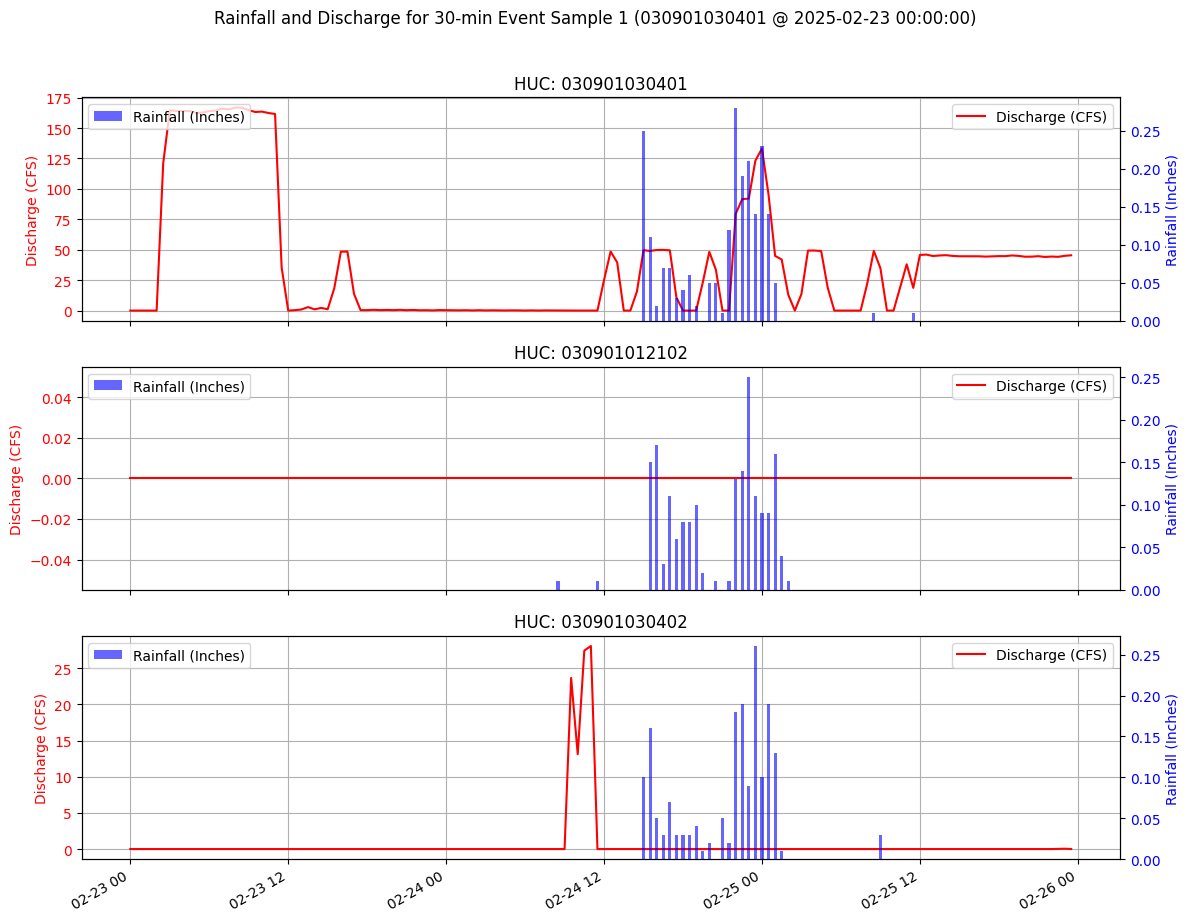


Sample 2/3:
  Triggering HUC ID: 030901012101
  Event Start Time (30-min): 2025-09-22 00:00:00
  Rainfall Data Shape: (144, 5)
  Discharge Data Shape: (144, 5)

  Visualizing Rainfall and Discharge for Sample 2 (030901012101 starting at 2025-09-22 00:00:00)


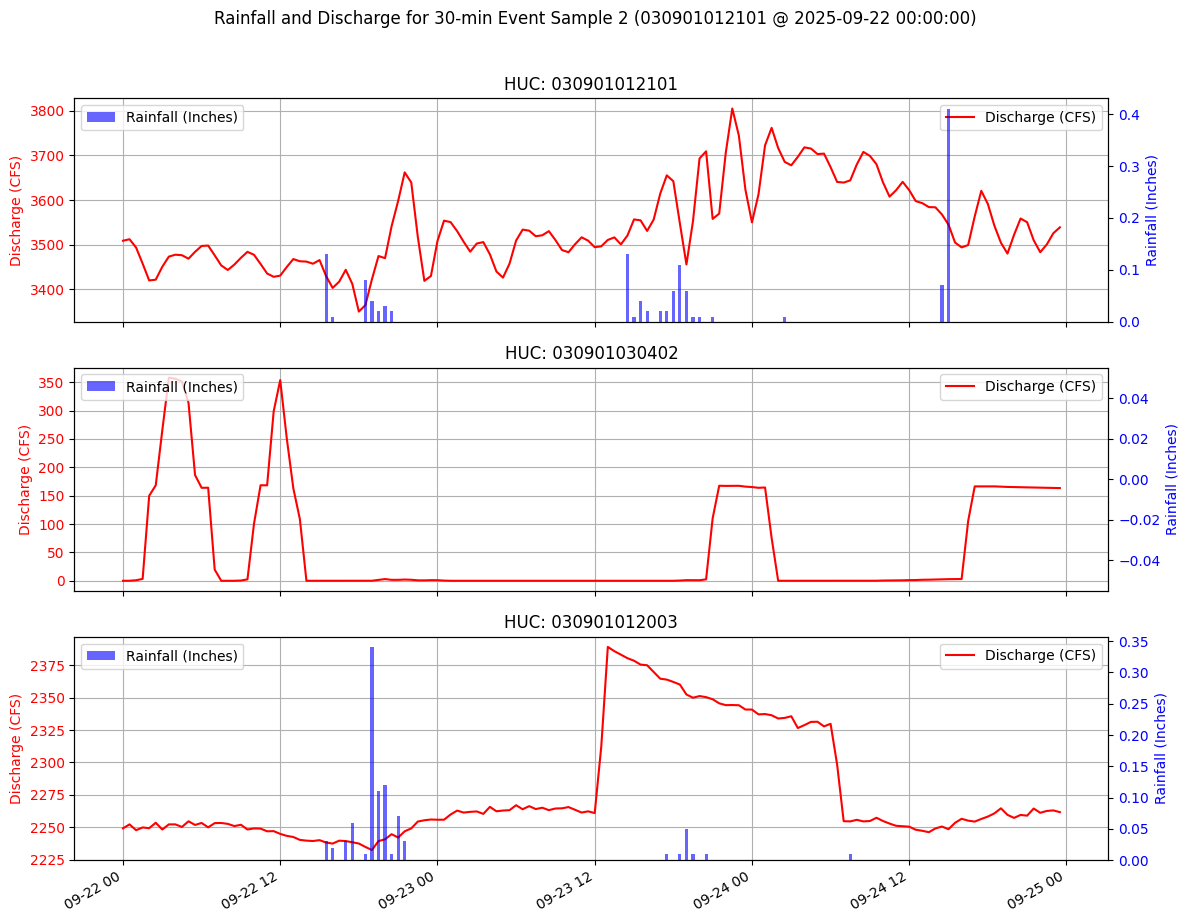


Sample 3/3:
  Triggering HUC ID: 030901030401
  Event Start Time (30-min): 2025-02-24 00:00:00
  Rainfall Data Shape: (144, 5)
  Discharge Data Shape: (144, 5)

  Visualizing Rainfall and Discharge for Sample 3 (030901030401 starting at 2025-02-24 00:00:00)


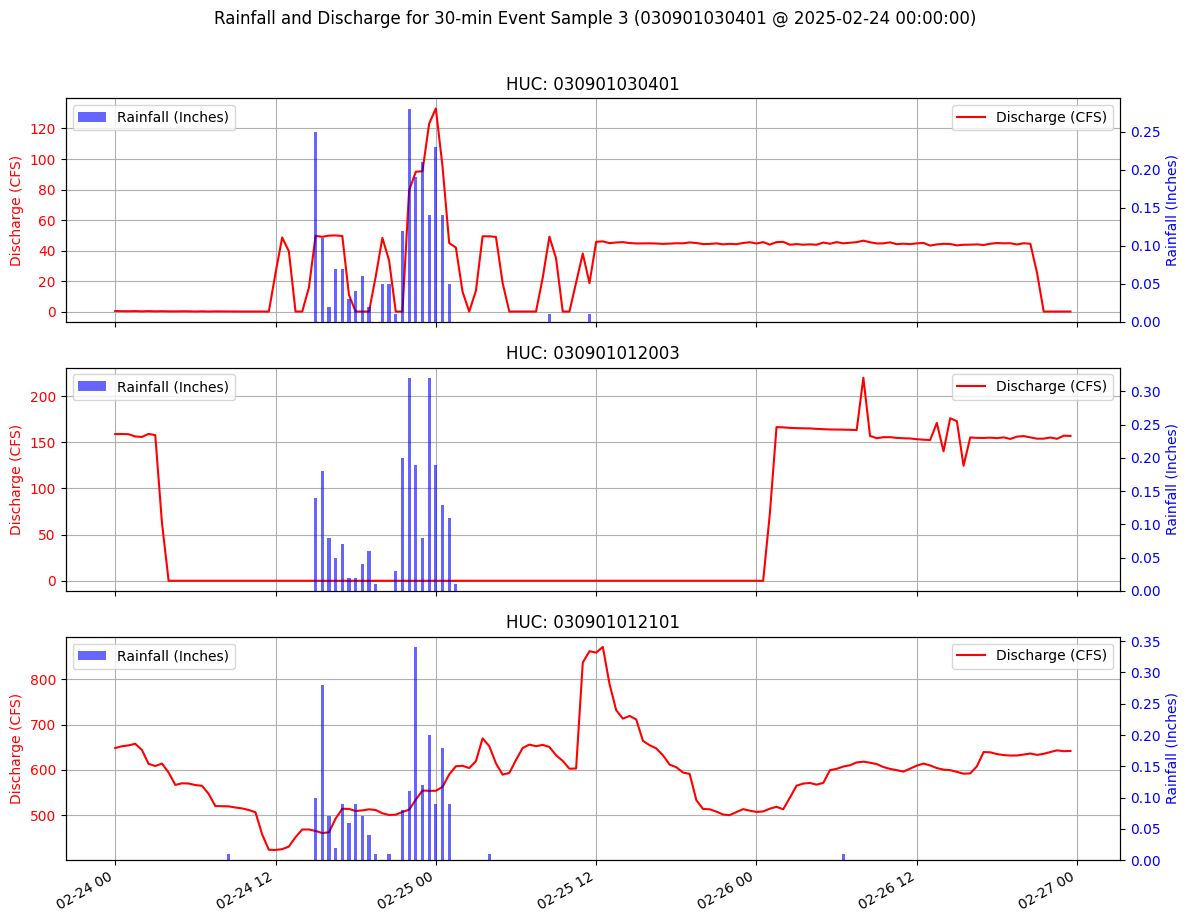

In [47]:
import matplotlib.pyplot as plt
import random

# Ensure event_samples_30min, NUM_NODES are available.
# Assume huc_ids are available (e.g., from data_matrix_X_30min.columns)

if 'huc_ids' not in locals():
    print("\nWarning: huc_ids not found. Using column names from data_matrix_X_30min.")
    try:
        huc_ids = data_matrix_X_30min.columns.tolist()
    except NameError:
         print("\nError: data_matrix_X_30min not found. Cannot determine HUC IDs for visualization.")
         huc_ids = [f'HUC_{i+1}' for i in range(NUM_NODES)] # Fallback to generic labels


# Select a few random event samples to examine
num_samples_to_examine = 3
if len(event_samples_30min) < num_samples_to_examine:
    num_samples_to_examine = len(event_samples_30min)
    print(f"\nWarning: Only {len(event_samples_30min)} event samples available, examining all.")

random_sample_indices = random.sample(range(len(event_samples_30min)), num_samples_to_examine)

print(f"\n--- Examining {num_samples_to_examine} Random 30-minute Event Samples ---")

for i, sample_index in enumerate(random_sample_indices):
    sample = event_samples_30min[sample_index]
    event_huc_id = sample['event_huc_id']
    event_start_time_30min = sample['event_start_time_30min']
    rainfall_data_30min = sample['rainfall_data_30min'] # Shape (144, NUM_NODES)
    discharge_data_30min = sample['discharge_data_30min'] # Shape (144, NUM_NODES)

    print(f"\nSample {i+1}/{num_samples_to_examine}:")
    print(f"  Triggering HUC ID: {event_huc_id}")
    print(f"  Event Start Time (30-min): {event_start_time_30min}")
    print(f"  Rainfall Data Shape: {rainfall_data_30min.shape}")
    print(f"  Discharge Data Shape: {discharge_data_30min.shape}")

    # Create time index for plotting (144 steps at 30-min frequency)
    time_index_30min = pd.date_range(start=event_start_time_30min, periods=EVENT_WINDOW_STEPS, freq='30min')


    # Visualize rainfall and discharge for selected HUCs within this sample
    print(f"\n  Visualizing Rainfall and Discharge for Sample {i+1} ({event_huc_id} starting at {event_start_time_30min})")

    # Choose a few HUCs to plot (e.g., the triggering HUC and a couple of others)
    hucs_to_plot = [event_huc_id]
    other_hucs = [h for h in huc_ids if h != event_huc_id]
    hucs_to_plot.extend(random.sample(other_hucs, min(2, len(other_hucs)))) # Add up to 2 other HUCs

    fig, axes = plt.subplots(nrows=len(hucs_to_plot), ncols=1, figsize=(12, len(hucs_to_plot) * 3), sharex=True)
    fig.suptitle(f'Rainfall and Discharge for 30-min Event Sample {i+1} ({event_huc_id} @ {event_start_time_30min})', y=1.02)

    for j, plot_huc_id in enumerate(hucs_to_plot):
        # Get the index of the HUC in the data arrays
        try:
            huc_index = huc_ids.index(plot_huc_id)
        except ValueError:
            print(f"Warning: HUC ID {plot_huc_id} not found in huc_ids list. Skipping plot for this HUC.")
            continue

        ax = axes[j] if len(hucs_to_plot) > 1 else axes

        # Plot Rainfall (on a secondary y-axis)
        ax_twin = ax.twinx()
        ax_twin.bar(time_index_30min, rainfall_data_30min[:, huc_index], width=0.01, alpha=0.6, color='blue', label='Rainfall (Inches)')
        ax_twin.set_ylabel('Rainfall (Inches)', color='blue')
        ax_twin.tick_params(axis='y', labelcolor='blue')
        ax_twin.legend(loc='upper left')

        # Plot Discharge
        ax.plot(time_index_30min, discharge_data_30min[:, huc_index], color='red', label='Discharge (CFS)')
        ax.set_ylabel('Discharge (CFS)', color='red')
        ax.tick_params(axis='y', labelcolor='red')
        ax.legend(loc='upper right')

        ax.set_title(f'HUC: {plot_huc_id}')
        ax.grid(True)

    # Format x-axis (dates and times)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

## 9. Prepare Data for Model (Final Arrays)

**Subtask:** Ensure the final NumPy arrays (`X_events_30min` and `y_events_30min`) are ready for splitting into training/testing sets and input into a spatio-temporal model.

**Reasoning:** Print the final shapes of the prepared input and target arrays to confirm they are in the expected format for model training. These arrays can now be split and used to train a model that takes samples of shape (144, NUM_NODES, Total_Features) and predicts sequences of shape (144, NUM_NODES).

In [48]:
# Ensure X_events_30min and y_events_30min are available from step 7.

print("\n--- Final Prepared Data for Model Training ---")
print(f"Input Samples (X_events_30min) shape: {X_events_30min.shape}")
print(f"Target Samples (y_events_30min) shape: {y_events_30min.shape}")

print("\nData preparation complete. These arrays are ready for splitting and model training.")


--- Final Prepared Data for Model Training ---
Input Samples (X_events_30min) shape: (151, 144, 5, 16)
Target Samples (y_events_30min) shape: (151, 144, 5)

Data preparation complete. These arrays are ready for splitting and model training.


## Finish task
The data has been successfully prepared into 3-day, 30-minute event-based samples, incorporating static basin characteristics and structured into NumPy arrays (`X_events_30min` and `y_events_30min`) suitable for training a spatio-temporal model.

## 1. Split Data into Training and Testing Sets

**Subtask:** Divide the prepared `X_events_30min` and `y_events_30min` arrays into training and testing sets.

**Reasoning:** Split the event samples into training and testing sets using a defined ratio (e.g., 80/20) to prepare the data for model training and evaluation.

In [49]:
from sklearn.model_selection import train_test_split

# Ensure X_events_30min and y_events_30min are available from the previous data preparation steps.

# Define the split ratio
TEST_SIZE = 0.2 # 20% for testing, 80% for training

print(f"Splitting data into training and testing sets with a test size of {TEST_SIZE}...")

# Split the data
X_train_events, X_test_events, y_train_events, y_test_events = train_test_split(
    X_events_30min,
    y_events_30min,
    test_size=TEST_SIZE,
    random_state=42 # Use a fixed random state for reproducibility
)

print("\n--- Data Split Complete ---")
print(f"X_train_events shape: {X_train_events.shape}")
print(f"y_train_events shape: {y_train_events.shape}")
print(f"X_test_events shape: {X_test_events.shape}")
print(f"y_test_events shape: {y_test_events.shape}")

# Verify the number of samples in each set
print(f"\nTotal number of event samples: {X_events_30min.shape[0]}")
print(f"Number of training samples: {X_train_events.shape[0]}")
print(f"Number of testing samples: {X_test_events.shape[0]}")

Splitting data into training and testing sets with a test size of 0.2...

--- Data Split Complete ---
X_train_events shape: (120, 144, 5, 16)
y_train_events shape: (120, 144, 5)
X_test_events shape: (31, 144, 5, 16)
y_test_events shape: (31, 144, 5)

Total number of event samples: 151
Number of training samples: 120
Number of testing samples: 31


## 2. Design Spatio-Temporal Model Architecture

**Subtask:** Define a model architecture that can process the input data shape (Number of Events, 144, Number of Nodes, Number of Features) and predict the output shape (Number of Events, 144, Number of Nodes).

**Reasoning:** Define a GCN-GRU model using Keras. The model will consist of a custom GCN layer to handle the spatial relationships on the graph and GRU layers to capture the temporal dynamics within each event window. The input will be the combined dynamic and static features, and the output will be the predicted discharge time series for all nodes over the event window.

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from typing import Tuple

# Assume NUM_NODES, EVENT_WINDOW_STEPS, total_features_30min, and A_norm are available from previous steps.

# Redefine the GCN Layer class as it's needed for the model definition in this new cell
class GCNLayer(tf.keras.layers.Layer):
    """
    Graph Convolutional Layer: H' = A_norm * H * W
    Where A_norm is the normalized Adjacency Matrix,
    H is the Node Features, and W is the trainable weight matrix.
    This version operates on batched spatio-temporal data.
    Input shape: (batch_size, time_steps, num_nodes, feature_dim)
    Output shape: (batch_size, time_steps, num_nodes, output_dim)
    """
    def __init__(self, output_dim, activation='relu', **kwargs):
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        super(GCNLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Input shape is (batch, time, nodes, features) -> we only care about features
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.output_dim),
                                      initializer='glorot_uniform',
                                      name='kernel')
        super(GCNLayer, self).build(input_shape)

    def call(self, inputs):
        # Inputs: (batch_size, time_steps, num_nodes, feature_dim) -> Features H
        # A_norm: (num_nodes, num_nodes) -> Normalized Adjacency Matrix (passed directly)

        # Reshape inputs for batch processing with einsum: (batch*time, num_nodes, feature_dim)
        H = tf.reshape(inputs, (-1, tf.shape(inputs)[-2], tf.shape(inputs)[-1]))

        # 1. H * W (Feature transformation)
        # H_W: (batch*time, num_nodes, output_dim)
        H_W = tf.einsum('ijk,kp->ijp', H, self.kernel)

        # 2. A_norm * (H * W) (Spatial aggregation/Graph Convolution)
        # Use the A_norm tensor (assuming it's a tf.constant or variable outside the layer)
        # A_H_W: (batch*time, num_nodes, output_dim)
        # tf.constant(A_norm, dtype=tf.float32) ensures A_norm is treated as a tensor
        A_H_W = tf.einsum('ij,bjk->bik', tf.constant(A_norm, dtype=tf.float32), H_W)

        # Reshape back to (batch_size, time_steps, num_nodes, output_dim)
        output = tf.reshape(A_H_W, (tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[-2], self.output_dim))

        return self.activation(output)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.output_dim)


def build_event_based_gcn_gru_model(
    input_shape: Tuple,       # Shape of a single event sample (144, NUM_NODES, Total_Features)
    num_nodes: int,
    output_steps: int,        # Number of time steps to predict (144)
    gcn_output_dim: int = 32, # Output feature dimension of the GCN layer
    gru_units: int = 64,      # Number of units in the GRU layer
    dropout_rate: float = 0.3 # Dropout rate
) -> Model:
    """Defines the event-based Spatio-Temporal GCN-GRU model."""

    # Input layer for the combined event features (144, NUM_NODES, Total_Features)
    event_input = Input(shape=input_shape, name='event_input')

    # Apply GCN layer to capture spatial features at each time step.
    # Use TimeDistributed to apply the GCN layer independently to each time step.
    # The GCN layer expects (batch, time, nodes, features) and outputs (batch, time, nodes, gcn_output_dim)
    # However, our GCNLayer is designed to handle the time dimension internally via reshape.
    # So we can directly apply it.
    gcn_out = GCNLayer(output_dim=gcn_output_dim, activation='relu', name='gcn_layer')(event_input)


    # Reshape the output of the GCN layer to feed into the GRU.
    # We want to treat this as a sequence of features for each time step.
    # Shape before reshape: (batch, time, nodes, gcn_output_dim)
    # Shape after reshape: (batch, time, nodes * gcn_output_dim)
    reshaped_for_rnn = Reshape(
        (EVENT_WINDOW_STEPS, num_nodes * gcn_output_dim),
        name='reshape_for_rnn'
    )(gcn_out)

    # Apply GRU layer to capture temporal dependencies across the 144 time steps.
    # Since we want to predict the *entire* 144-step sequence, we need `return_sequences=True`.
    gru_out = GRU(units=gru_units, activation='relu', return_sequences=True, name='gru_layer')(reshaped_for_rnn)

    # Apply Dropout for regularization
    gru_out = Dropout(dropout_rate, name='dropout')(gru_out)

    # Output Layer
    # We need to output a prediction for each node at each time step.
    # The GRU output shape is (batch, time, nodes * gru_units).
    # We need to map this to (batch, time, nodes).
    # Use TimeDistributed(Dense) to apply a Dense layer independently to each time step.
    # The Dense layer will map from (nodes * gru_units) to nodes (for discharge prediction for each node).
    output_dense = TimeDistributed(Dense(num_nodes, name='output_dense'), name='time_distributed_output')(gru_out)


    # The model inputs the event data and outputs the predicted discharge sequence
    model = Model(inputs=event_input, outputs=output_dense)
    return model

# Build the model with the defined parameters
event_model = build_event_based_gcn_gru_model(
    input_shape=X_train_events.shape[1:], # Shape of a single sample (144, 5, 16)
    num_nodes=NUM_NODES,
    output_steps=EVENT_WINDOW_STEPS, # Predict 144 time steps
    gcn_output_dim=32,
    gru_units=64,
    dropout_rate=0.3
)

# Compile the model
event_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Print the model summary
event_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)        │ (None, 144, 5, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gcn_layer (GCNLayer)            │ (None, 144, 5, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (Reshape)       │ (None, 144, 160)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer (GRU)                 │ (None, 144, 64)        │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 144, 5)         │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,229 (172.77 KB)

 Trainable params: 44,229 (172.77 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model

**Subtask:** Train the implemented model using the training data.

**Reasoning:** Use the `fit` method of the compiled Keras model to train it on the training data (`X_train_events`, `y_train_events`). Specify the number of epochs and batch size. Include an Early Stopping callback to monitor validation performance and stop training early if the model starts overfitting.

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

# Ensure event_model, X_train_events, y_train_events, X_test_events, y_test_events are available.

# Define training parameters
EPOCHS = 50 # You can adjust this based on how the training progresses
BATCH_SIZE = 32 # You can adjust this based on your memory capacity and dataset size

print(f"Starting model training for {EPOCHS} epochs with a batch size of {BATCH_SIZE}...")

# Define Early Stopping callback
# Monitor validation loss and stop if it doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = event_model.fit(
    X_train_events,
    y_train_events,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_events, y_test_events),
    callbacks=[early_stopping],
    verbose=2 # Set to 1 for progress bar, 2 for one line per epoch
)

print("\nModel training complete.")

# The 'history' object contains information about the training process (loss, metrics per epoch).

Starting model training for 50 epochs with a batch size of 32...
Epoch 1/50
4/4 - 12s - 3s/step - loss: 0.9153 - mae: 0.6168 - val_loss: 0.9328 - val_mae: 0.5519
Epoch 2/50
4/4 - 1s - 216ms/step - loss: 0.6904 - mae: 0.5363 - val_loss: 0.7572 - val_mae: 0.4999
Epoch 3/50
4/4 - 1s - 201ms/step - loss: 0.5572 - mae: 0.4994 - val_loss: 0.6361 - val_mae: 0.4546
Epoch 4/50
4/4 - 1s - 213ms/step - loss: 0.4873 - mae: 0.4722 - val_loss: 0.5235 - val_mae: 0.4197
Epoch 5/50
4/4 - 1s - 305ms/step - loss: 0.4058 - mae: 0.4358 - val_loss: 0.4223 - val_mae: 0.3754
Epoch 6/50
4/4 - 1s - 205ms/step - loss: 0.3309 - mae: 0.3934 - val_loss: 0.3311 - val_mae: 0.3350
Epoch 7/50
4/4 - 1s - 209ms/step - loss: 0.2699 - mae: 0.3562 - val_loss: 0.2245 - val_mae: 0.2907
Epoch 8/50
4/4 - 1s - 203ms/step - loss: 0.2066 - mae: 0.3188 - val_loss: 0.1222 - val_mae: 0.2318
Epoch 9/50
4/4 - 1s - 308ms/step - loss: 0.1682 - mae: 0.2898 - val_loss: 0.0747 - val_mae: 0.1832
Epoch 10/50
4/4 - 1s - 347ms/step - loss: 0.15